# Идея

todo

In [1]:
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, glob, os
import random
import torch
from collections import deque

import gym
from gym import error, spaces, utils
from gym.utils import seeding

In [2]:
from ddpg_agent import Agent

### Env

In [3]:
# true system params
big_b=1
big_omega=1
theta=0
m=1
k=0.1
beta=0.02
big_f_0=1
n_steps=100
t_min=0
t_max=10

t0 = 0
step = 0.3
n_steps = 100

delta = beta / (2 * m)
omega_0 = k / m

In [4]:
def x_force(t):
    if t <= 0:
        return 1
    return np.exp(-t * 0.05)

def x_pendulum(t, big_b, big_omega, theta):
    return big_b * np.cos(big_omega * t - theta)

def generate_history(t0, step, n_steps, big_b=big_b, big_omega=big_omega, theta=theta,
                     x_force=x_force, x_pendulum=x_pendulum):
    res = []
    for _ in range(n_steps):
        res.append(
            x_pendulum(t0, big_b, big_omega, theta) * x_force(t0)
        )
        t0 += step
    return res

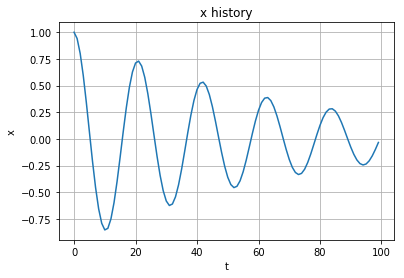

In [5]:
history = generate_history(t0, step, n_steps)
plt.title("x history")
plt.xlabel("t")
plt.ylabel("x")
plt.grid(True)
plt.plot(history)
plt.show()

In [6]:
class SimpleModel(gym.Env):
    
    def __init__(self, history, t0=t0, step=step, n_steps=n_steps, big_f_0=big_f_0, k=k):
        self._history = history
        self._big_f_0 = big_f_0
        self._k = k

        self._i = 0
        self._last_x = self._history[0]
        self._t0 = t0
        self.t = t0
        self._step = step
        self._n_steps = n_steps
        
        self.observation_space = spaces.Box(low=-100, high=100, shape=(1,), dtype=np.float32)
        self.action_space = spaces.Box(np.array([0,-2,-.1]), np.array([+10,+2,+.1]), dtype=np.float32)
 
        
    def _x_model(self, m, delta, big_omega):
        """Returns the model position."""
        big_b = self._big_b_model(m, delta, big_omega)
        theta = self._theta_model(m, delta, big_omega)
        return big_b * np.cos(big_omega * self.t - theta)
    
    def _big_b_model(self, m, delta, big_omega):
        omega_0_sqr = self._k / m
        f_0 = self._big_f_0 / m
        
        res = (omega_0_sqr**2 - big_omega**2)**2
        res += 4 * delta**2 * big_omega**2
        res = f_0 / res**0.5
        return res
    
    def _theta_model(self, m, delta, big_omega):
        omega_0_sqr = self._k / m
        
        res = 2 * delta * big_omega
        res /= omega_0_sqr - big_omega**2
        return res
    
    def step(self, action):

        # step
        self._i += 1
        self.t += self._step

        # reward
        m_, delta_, big_omega_ = action[0], action[1], action[2]
        big_b_ = self._big_b_model(m_, delta_, big_omega_)
        theta_ = self._theta_model(m_, delta_, big_omega_)
        x_ = self._x_model(m_, delta_, big_omega_)
        reward = - (x_ - self._history[self._i]) ** 2

        # done
        done = self._i >= self._n_steps - 1
        
        # info
        info = {}
        
        # obs
        self._last_x = x_
        obs = np.array(self._last_x).reshape((1,1))
        
        return obs, reward, done, info
    
    def reset(self):
        self._i = 0
        self.t = self._t0
        self._last_x = self._history[0]
        return np.array(self._last_x).reshape((1,1))
    
    def render(self):
        pass

    

In [7]:
class ForceWrapper(gym.ObservationWrapper):
    
    def __init__(self, env, force_func):
        super().__init__(env)
        self.force_func = force_func
        self.observation_space = spaces.Box(low=-100, high=100, shape=(2,), dtype=np.float32)
    
    def step(self, action):
        o, r, d, info =  self.env.step(action)
        o = np.array([o[0][0], self.force_func(self.t)])
        return o, r, d, info
        
    def reset(self):
        o = self.env.reset()
        o = np.array([o[0][0], self.force_func(self.t)])
        return o

# Some tests

In [12]:
history = generate_history(t0, step, n_steps, x_force=lambda t: 100)
env = SimpleModel(history, t0, step, n_steps)

In [13]:
for i in range(20):
    env.reset()
    o, r, d, _ = env.step([m, delta, big_omega])
#     assert np.isclose(r, 0, atol=1e-5)
o, r, d, _ = env.step([m, delta, big_omega + 1])
# assert not np.isclose(r, 0, atol=1e-3)

reset_1 = env.reset()
for i in range(3):
    o, r, d, _ = env.step([0.1, 0.1, 0.1])
reset_2 = env.reset()
# assert reset_1 == reset_2

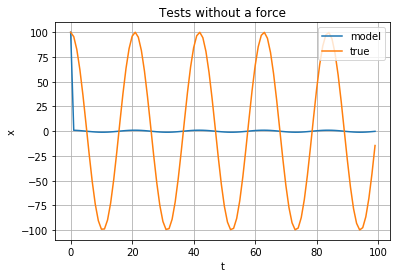

In [14]:
points = [env.reset()]
points += [env.step([m, delta, big_omega])[0] for _ in range(len(history) - 1)]
points = np.array(points).reshape((-1,))
# assert len(points) == len(history)
# for p, h in zip(*(points, history)):
#     assert np.isclose(p, h, atol=1e-1)
plt.plot(np.array(points).reshape((-1,1)), label="model")
plt.plot(history, label="true")
plt.grid(True)
plt.legend()
plt.title("Tests without a force")
plt.xlabel("t")
plt.ylabel("x")
plt.show()

In [15]:
history = generate_history(t0, step, n_steps, x_force=x_force)
env = SimpleModel(history, t0, step, n_steps)
env = ForceWrapper(env, x_force)

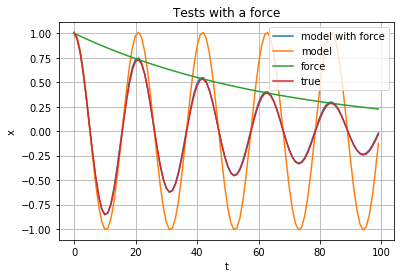

In [12]:
points = [env.reset()]
points += [env.step([m, delta, big_omega])[0] for _ in range(len(history) - 1)]
points = np.array(points).T

assert points[0].shape == points[1].shape
plt.plot(points[0]*points[1] + 0.01, label="model with force")
plt.plot(points[0], label="model")
plt.plot(points[1], label="force")
plt.plot(history, label="true")
plt.grid(True)
plt.legend()
plt.title("Tests with a force")
plt.xlabel("t")
plt.ylabel("x")
plt.show()

# CE

from https://github.com/udacity/deep-reinforcement-learning/blob/master/cross-entropy/CEM.ipynb

In [13]:
history = generate_history(t0, step, n_steps)
env = SimpleModel(history, t0, step, n_steps)
env = ForceWrapper(env, x_force)

In [14]:
import gym
import math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env.seed(101)
np.random.seed(101)

print('observation space:', env.observation_space)
print('action space:', env.action_space)
print('  - low:', env.action_space.low)
print('  - high:', env.action_space.high)

class Agent(nn.Module):
    def __init__(self, env, h_size=16):
        super(Agent, self).__init__()
        self.env = env
        # state, hidden layer, action sizes
        self.s_size = env.observation_space.shape[0]
        self.h_size = h_size
        self.a_size = env.action_space.shape[0]
        # define layers
        self.fc1 = nn.Linear(self.s_size, self.h_size)
        self.fc2 = nn.Linear(self.h_size, self.a_size)
        
    def set_weights(self, weights):
        s_size = self.s_size
        h_size = self.h_size
        a_size = self.a_size
        # separate the weights for each layer
        fc1_end = (s_size*h_size)+h_size
        fc1_W = torch.from_numpy(weights[:s_size*h_size].reshape(s_size, h_size))
        fc1_b = torch.from_numpy(weights[s_size*h_size:fc1_end])
        fc2_W = torch.from_numpy(weights[fc1_end:fc1_end+(h_size*a_size)].reshape(h_size, a_size))
        fc2_b = torch.from_numpy(weights[fc1_end+(h_size*a_size):])
        # set the weights for each layer
        self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))
    
    def get_weights_dim(self):
        return (self.s_size+1)*self.h_size + (self.h_size+1)*self.a_size
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return x.cpu().data
        
    def evaluate(self, weights, gamma=1.0, max_t=5000):
        self.set_weights(weights)
        episode_return = 0.0
        state = self.env.reset()
        for t in range(max_t):
            state = torch.from_numpy(state).float().to(device)
            action = self.forward(state)
            state, reward, done, _ = self.env.step(action.numpy())
            episode_return += reward * math.pow(gamma, t)
            if done:
                break
        return episode_return
    
agent = Agent(env).to(device)

observation space: Box(2,)
action space: Box(3,)
  - low: [ 0.  -2.  -0.1]
  - high: [10.   2.   0.1]


/home/dev/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Could not seed environment <SimpleModel instance>
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [16]:
def plot_result(env, agent):
    s = env.reset()
    d = False
    points = [s[0]]
    while not d:
        state = torch.from_numpy(s).float().to(device)
        a = list(agent(state).numpy())
        s, r, d, _ = env.step(a)
        points.append(s[0])

    plt.plot(points, label="model")
    plt.plot(history, label="true")
    plt.title("CE training")
    plt.xlabel("t")
    plt.ylabel("x")
    plt.grid(True)
    plt.legend()
    plt.show()

Episode 0	Average Score: -476.08
50.01 0.4995 70.014


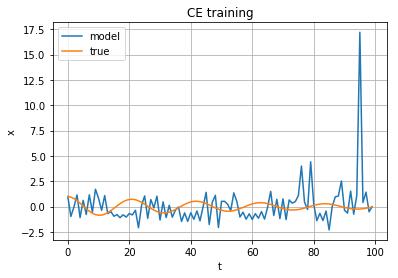

Episode 100	Average Score: -27.71
51.0201669879053 0.45194367748329795 71.42823378306743


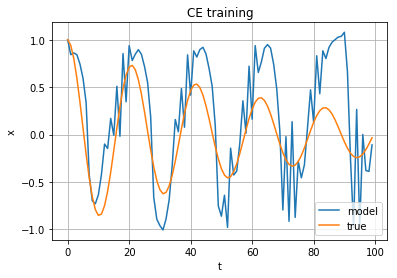

Episode 200	Average Score: -98.50
52.05073864174647 0.4089150903245787 72.8710340984451


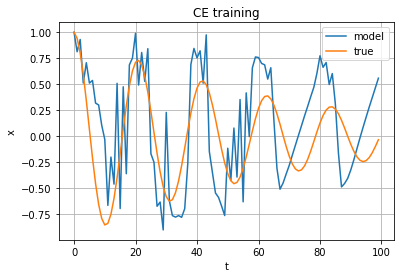

Episode 300	Average Score: -525.41
53.10212712149009 0.3699831625619718 74.34297797008618


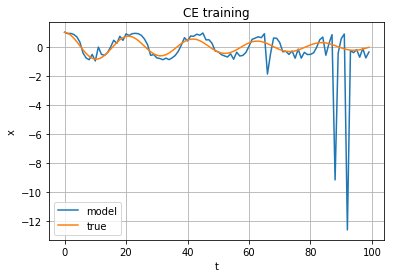

Episode 400	Average Score: -16.71
54.17475291244547 0.3347578600503668 75.8446540774238


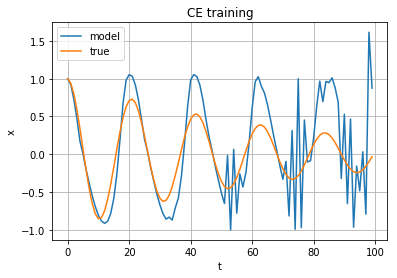

Episode 500	Average Score: -24.26
55.269044993430825 0.30288628295816183 77.37666299080331


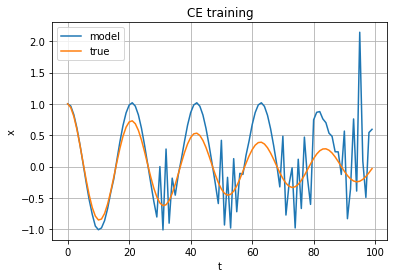

Episode 600	Average Score: -22.74
56.38544100833615 0.2740491302890055 78.93961741167072


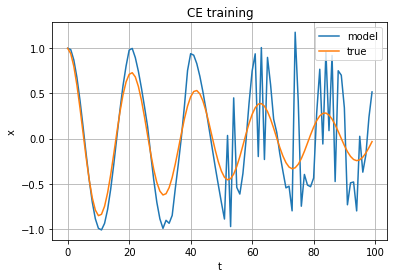

Episode 700	Average Score: -69.90
57.52438744115164 0.2479575010088339 80.53414241761243


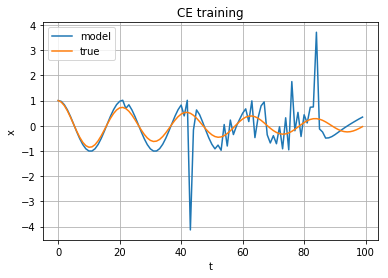

Episode 800	Average Score: -78.11
58.68633979453143 0.22434999973073239 82.16087571234422


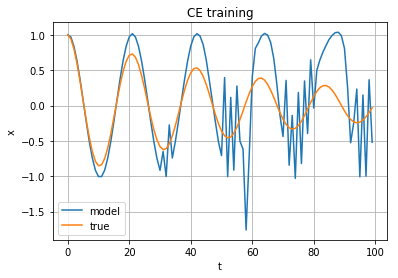

Episode 900	Average Score: -22.63
59.8717627719645 0.20299011796132935 83.8204678807505


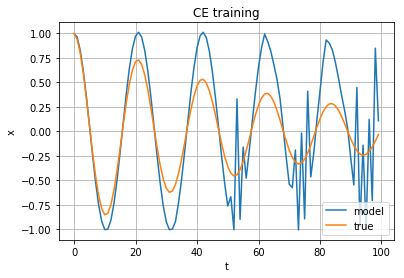

Episode 1000	Average Score: -16.62
61.081130463624866 0.18366386467309628 85.513582649075


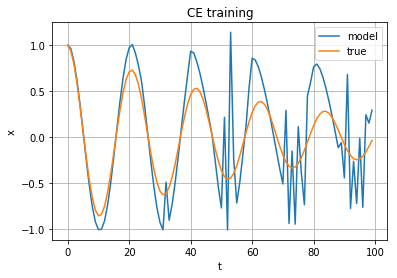

Episode 1100	Average Score: -11.39
62.314926535976234 0.16617762246477263 87.2408971503669


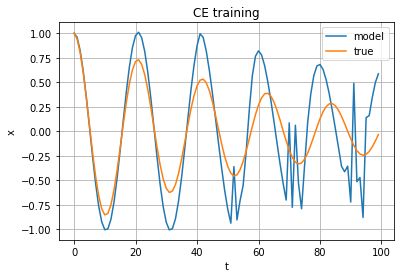

Episode 1200	Average Score: -12.52
63.57364442520614 0.1503562078321529 89.00310219528882


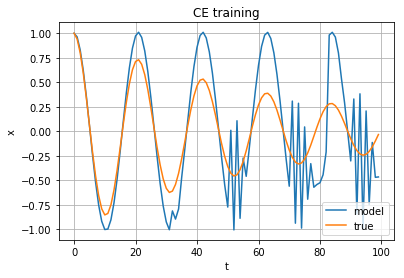

Episode 1300	Average Score: -13.55
64.85778753456768 0.1360411161163288 90.80090254839504


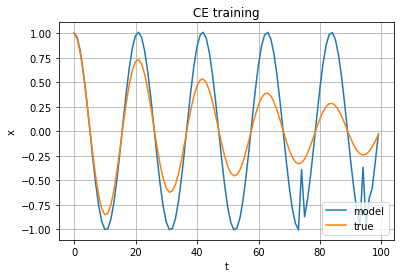

Episode 1400	Average Score: -11.16
66.16786943570737 0.12308893354663855 92.63501720999058


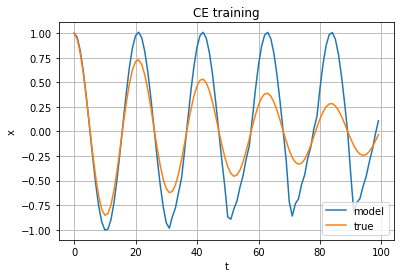

Episode 1500	Average Score: -10.05
67.5044140740593 0.11136990046959969 94.50617970368329


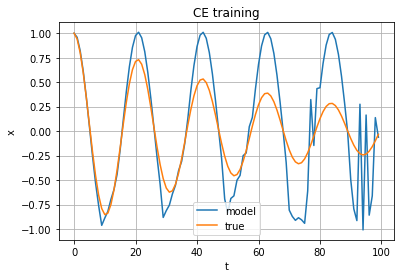

Episode 1600	Average Score: -13.94
68.86795597838848 0.10076661136972916 96.41513836974428


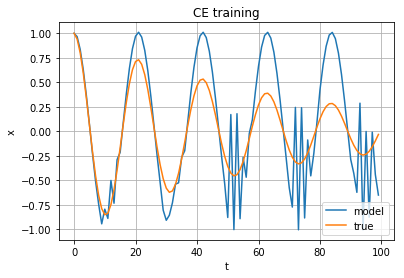

Episode 1700	Average Score: -17.43
70.25904047456693 0.09117283865858988 98.36265666439418


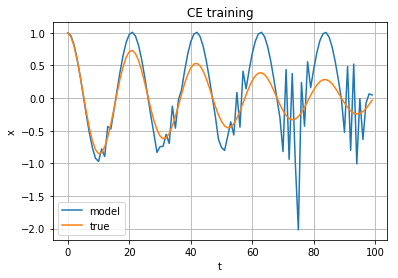

Episode 1800	Average Score: -23.94
71.67822390366726 0.08249246844835735 100


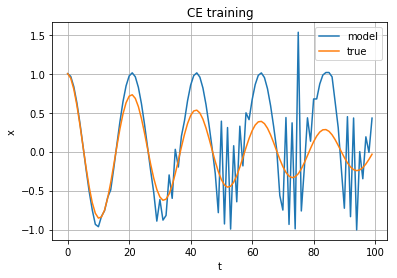

Episode 1900	Average Score: -279.23
73.1260738444625 0.07463853764809907 100


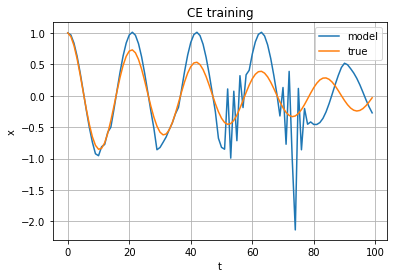

Episode 2000	Average Score: -282.85
74.60316934041937 0.06753236273605094 100


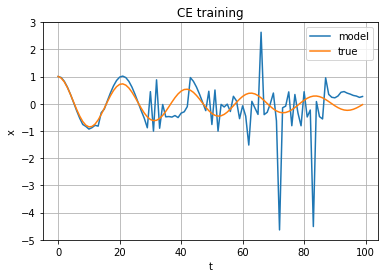

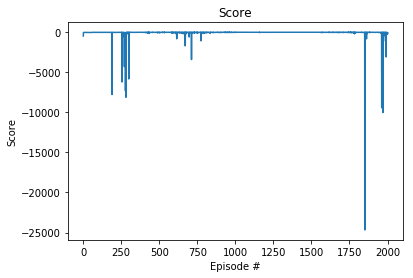

In [17]:
# TODO: improve CEM with CEM hacks

def cem(n_iterations=2000, max_t=1000, gamma=0.8, print_every=100, pop_size=50, percentile=70, sigma=0.5, new=True,
        c_pop_size=1.0002, c_sigma=0.9995, c_percentile=1.0002):
    """PyTorch implementation of the cross-entropy method.
        
    Params
    ======
        n_iterations (int): maximum number of training iterations
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        pop_size (int): size of population at each iteration
        elite_frac (float): percentage of top performers to use in update
        sigma (float): standard deviation of additive noise
    """
    scores_deque = deque(maxlen=100)
    scores = []
    
    if new:
        best_weight = sigma*np.random.randn(agent.get_weights_dim())

    for i_iteration in range(0, n_iterations+1):
        
        weights_pop = [best_weight + (sigma*np.random.randn(agent.get_weights_dim())) for i in range(int(pop_size))]
        rewards = np.array([agent.evaluate(weights, gamma, max_t) for weights in weights_pop])

#         elite_idxs = rewards.argsort()[-n_elite:]
        thr = np.percentile(rewards, percentile)
        elite_weights = [weights_pop[i] for i, r in enumerate(rewards) if r >= thr]
        best_weight = np.array(elite_weights).mean(axis=0)

        reward = agent.evaluate(best_weight, gamma=1.0)
        scores_deque.append(reward)
        scores.append(reward)
        
        
        pop_size *= c_pop_size
        
        sigma *= c_sigma
        sigma = max(0.0001, sigma)
        
        percentile *= c_percentile
        percentile = min(100, percentile)
        
        
        
        
        torch.save(agent.state_dict(), 'checkpoint.pth')
        
        if i_iteration % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))
            print(pop_size, sigma, percentile)
            plot_result(env, agent)

        if np.mean(scores_deque)>=-0.1:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration-100, np.mean(scores_deque)))
            break
    return scores

scores = cem()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Score')
plt.show()

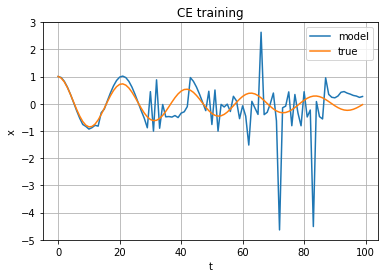

In [18]:
# load the weights from file
agent.load_state_dict(torch.load('checkpoint.pth'))

plot_result(env, agent)